# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files. It calculates the Nino3.4 index for the data to test which years have an El Nino event and if they occur after volcanic eruptions. 


In [85]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [86]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [147]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [175]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gr1.5

v20200302


In [179]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon

huss  pr  psl  tas  ts	uas  vas  wap


In [146]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [155]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [156]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [157]:
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model E3SM-1-0 has different time so is now removed
47 models have been successfully loaded into an xarray


In [158]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_ts.model), drop = True)
models_ts = models_ts.where(models_ts.model.isin(models_tas.model), drop = True)

#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_ts.model)

True

In [160]:
# get rid of models with issues
models = models_ts.drop_sel(model=['CIESM'])

In [161]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [162]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

## Nino 3.4

In [97]:
region = models_w.sel(lat=slice(-5,5), lon=slice(190,240))

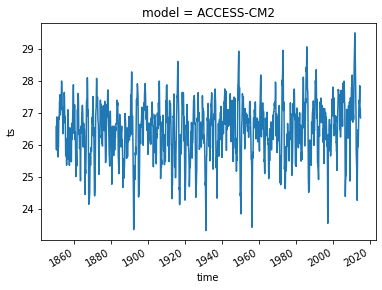

In [163]:
(region.sel(model='ACCESS-CM2').ts.mean(dim=['lat','lon'])-273).plot(size=4)

## check i did anomalies correctly

In [164]:
# calculate the mean climatology along each month
clim = region.sel(time = slice('1850-01', '1880-01')).groupby('time.month').mean(dim = ['time','lat','lon'])
clim

<xarray.Dataset>
Dimensions:  (model: 44, month: 12)
Coordinates:
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ts       (month, model) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

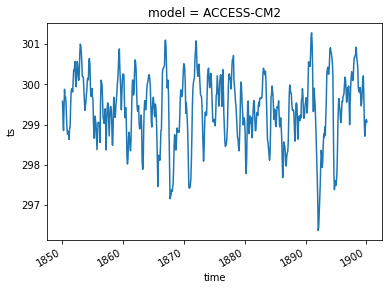

In [165]:
region.sel(model='ACCESS-CM2').ts.sel(time=slice('1850-01', '1900-01')).mean(dim=['lat','lon']).plot(size=4)

In [166]:
anom = (region.groupby('time.month') - clim).mean(dim=['lat','lon'])
anom

<xarray.Dataset>
Dimensions:  (model: 44, time: 1980)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ts       (model, time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

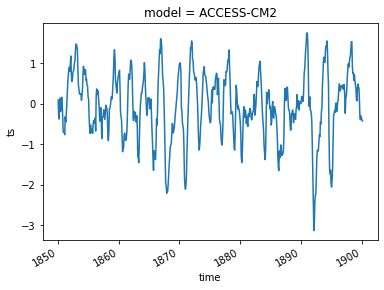

In [110]:
anom.sel(model='ACCESS-CM2').ts.sel(time=slice('1850-01', '1900-01')).plot(size=4)

In [167]:
std = region.sel(time=slice('1850-01', '1880-01')).mean(dim=['lat', 'lon']).std(dim = ['time'])
std

<xarray.Dataset>
Dimensions:  (model: 44)
Coordinates:
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    ts       (model) float64 dask.array<chunksize=(1,), meta=np.ndarray>

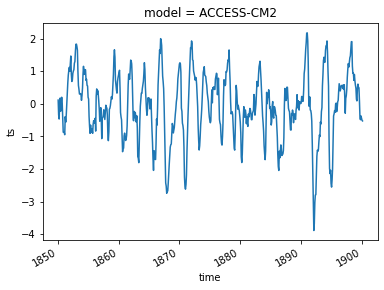

In [169]:
(anom/std).sel(model='ACCESS-CM2').ts.sel(time=slice('1850-01', '1900-01')).plot(size=4)

In [113]:
nino34 = anom.rolling(time=5).mean() / std
nion34

ValueError: For window size 5, every chunk should be larger than 2, but the smallest chunk size is 1. Rechunk your array
with a larger chunk size or a chunk size that
more evenly divides the shape of your array.

In [170]:
years = pd.date_range(ds.time.data[0], ds.time.data[-1], freq='Y')

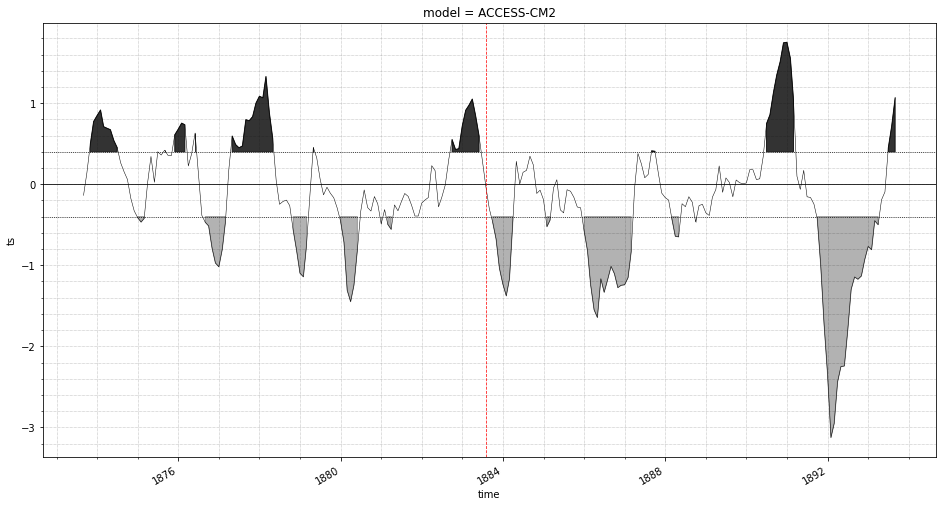

In [145]:
ds = anom.sel(model='ACCESS-CM2').ts.sel(time=slice('1873-08','1893-08'))
fig, ax = plt.subplots(figsize=(16,8))
# plot gridlines
ax.grid(which='major', ls=':', lw='0.5', color='grey') # customise major grid
ax.minorticks_on() # need this line in order to get the minor grid lines 
ax.grid(which='minor', ls=':', lw='0.5', color='grey')
ax.set_axisbelow(True) # sets the gridlines behind the data
# years = pd.date_range(ds.time.data[0], ds.time.data[-1], freq='A')
# ax.set_xticks(years.values)

#plot data and fill if it's over the thresholds
ax.fill_between(ds.time.values, ds.where(ds>=0.4).values, 0.4, color='k', alpha=0.8)
ax.fill_between(ds.time.values, ds.where(ds<=-0.4).values, -0.4, color='k', alpha=0.3)
ds.plot(color='k', lw=0.5)
ax.axhline(0, color='k', lw=0.8)
ax.axhline(0.4, color='k', lw=0.8, linestyle = ':')
ax.axhline(-0.4, color='k', lw=0.8, linestyle = ':')

#ax.title('Nino 3.4 region (threshold = 0.4 $\degree$C)')

ax.axvline(x=e_date[0], color = 'red', linestyle = '--', alpha = 0.9, linewidth='0.8')


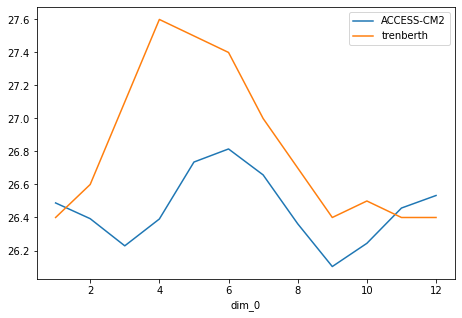

In [104]:
(clim.sel(model='ACCESS-CM2').ts - 273).plot(size=5, label = 'ACCESS-CM2') # makes a temporary datset 
mean_sst_trenberth = xr.DataArray([26.4, 26.6, 27.1, 27.6, 27.5, 27.4, 27.0, 26.7, 26.4, 26.5, 26.4, 26.4], coords=[np.arange(12)+1])
mean_sst_trenberth.plot(label='trenberth')
plt.legend()

In [172]:
dataset = nino34_final.sel(model='ACCESS-CM2').ts
dataset

NameError: name 'nino34_final' is not defined

In [115]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [171]:
# recreate figure from trenberth paper as an extension
fig = plt.figure(figsize=(16,8))
# alpha is the opacity 
plt.fill_between(dataset.time.values, dataset.where(dataset>=0.4).values, 0.4, color='k', alpha=0.8)
plt.fill_between(dataset.time.values, dataset.where(dataset<=-0.4).values, -0.4, color='k', alpha=0.3)
dataset.plot(color='k', lw=0.5)
plt.axhline(0, color='k', lw=0.8)
plt.axhline(0.4, color='k', lw=0.8, linestyle = ':')
plt.axhline(-0.4, color='k', lw=0.8, linestyle = ':')
plt.title('Nino 3.4 region (threshold = 0.4 $\degree$C)')

for date in e_date:
    plt.axvline(x=date, color = 'red', linestyle = '--', alpha = 0.9, linewidth='0.8')

NameError: name 'dataset' is not defined

<Figure size 1152x576 with 0 Axes>

In [ ]:
# percentage of el nino events
"percentage of el nino events = {:0.1f}%".format(100 * (nino34_final.where(nino34_final>=0.4).count() / nino34_final.count()).values)